In [4]:
import json
import os

sat2stat_file_path = os.path.join("dataset", "sat2stat_efficiency.json")


# Write the dictionary to a file in JSON format
with open(sat2stat_file_path, 'r') as file:
    communication_efficiency_sat2stat = json.load(file)
    
    
sat2sat_file_path = os.path.join("dataset", "sat2sat_efficiency.json")


# Write the dictionary to a file in JSON format
with open(sat2sat_file_path, 'r') as file:
    communication_efficiency_sat2sat = json.load(file)

In [5]:
def generate_graph(communication_efficiency_sat2stat, communication_efficiency_sat2sat, threshold = 0):    
    G = {}
    ground_stations = set()
    satellites = set()

    # Add edges from satellite to satellite
    for sat1, connections in communication_efficiency_sat2sat.items():
        satellites.add(sat1)
        G[sat1] = G.get(sat1, {})
        for sat2, efficiency in connections.items():
            if efficiency > threshold:
                G[sat1][sat2] = efficiency  # Edge weight is efficient

    # Add edges from ground station to satellite
    for station, connections in communication_efficiency_sat2stat.items():
        ground_stations.add(station)
        G[station] = G.get(station, {})
        for sat, efficiency in connections.items():
            if efficiency > threshold:
                G[station][sat] = efficiency  # Edge weight is efficiency
    return G, ground_stations, satellites

In [6]:
threshold = 0.0

In [7]:
G, ground_stations, satellites = generate_graph(communication_efficiency_sat2stat, communication_efficiency_sat2sat, threshold)

In [8]:
from collections import deque

def multi_source_bfs(G, ground_stations, satellites):
    shortest_paths = {sat: {} for sat in satellites}
    for gs in ground_stations:
        # Initialize the queue for BFS
        queue = deque([gs])
        visited = {node: False for node in G}
        visited[gs] = True
        prev = {node: None for node in G}

        # BFS from the ground station
        while queue:
            u = queue.popleft()
            for v in G[u]:
                if not visited[v]:
                    visited[v] = True
                    prev[v] = u
                    queue.append(v)

        # Reconstruct the shortest paths
        for satellite in satellites:
            if visited[satellite]:
                path = []
                current = satellite
                while current is not None:
                    path.insert(0, current)
                    current = prev[current]
                shortest_paths[satellite][gs] = path

    return shortest_paths

In [9]:
# Calculate the shortest paths
shortest_paths = multi_source_bfs(G, ground_stations, satellites)

In [10]:
shortest_paths

{'STARLINK-1815': {'Singapore': ['Singapore',
   'STARLINK-1020',
   'STARLINK-1021',
   'STARLINK-1815'],
  'Amsterdam': ['Amsterdam',
   'STARLINK-1199',
   'STARLINK-5876',
   'STARLINK-1815'],
  'London': ['London', 'STARLINK-1199', 'STARLINK-5876', 'STARLINK-1815'],
  'Beijing': ['Beijing', 'STARLINK-1021', 'STARLINK-1815'],
  'New Delhi': ['New Delhi',
   'STARLINK-1019',
   'STARLINK-1067',
   'STARLINK-1815'],
  'Seoul': ['Seoul', 'STARLINK-1021', 'STARLINK-1815'],
  'Ottawa': ['Ottawa', 'STARLINK-1054', 'STARLINK-1048', 'STARLINK-1815'],
  'Washington D.C.': ['Washington D.C.',
   'STARLINK-1054',
   'STARLINK-1048',
   'STARLINK-1815'],
  'Moscow': ['Moscow', 'STARLINK-1269', 'STARLINK-1281', 'STARLINK-1815'],
  'Paris': ['Paris', 'STARLINK-1199', 'STARLINK-5876', 'STARLINK-1815'],
  'Canberra': ['Canberra', 'STARLINK-1080', 'STARLINK-1160', 'STARLINK-1815'],
  'Jerusalem': ['Jerusalem',
   'STARLINK-1269',
   'STARLINK-1281',
   'STARLINK-1815'],
  'Berlin': ['Berlin', 'STAR

In [11]:
len(shortest_paths)

5242

In [12]:
#remove the satellites that can not connect all the ground station
satellites_to_delete = {satellite  for satellite in shortest_paths
 if len(shortest_paths
[satellite])<len(ground_stations)}

for satellite in satellites_to_delete:
    del shortest_paths[satellite]

In [13]:
len(shortest_paths)

5229

In [14]:
def calculate_unique_satellites(paths):
    unique_satellites = set()
    for path in paths.values():
        unique_satellites.update(set(path))
    return unique_satellites

def create_constellation(shortest_paths, ground_stations):
    satellite_efficiency = {}
    for sat, paths in shortest_paths.items():
        unique_satellites = calculate_unique_satellites(paths)
        # Efficiency is the number of unique satellites in all paths
        satellite_efficiency[sat] = len(unique_satellites)

    # Sort satellites by their efficiency (fewer unique satellites is better)
    sorted_satellites = sorted(satellite_efficiency, key=satellite_efficiency.get)

    
    most_efficient_satellite = sorted_satellites[0]
    constellation_paths = shortest_paths[most_efficient_satellite]

    return most_efficient_satellite, constellation_paths, satellite_efficiency[most_efficient_satellite]-len(ground_stations)

# Example usage
most_efficient_satellite, constellation_paths, num_satellites = create_constellation(shortest_paths, ground_stations)
print(f"Most efficient satellite: {most_efficient_satellite}")
print(f"Paths for the constellation: {constellation_paths}")
print(f"Total {num_satellites} satellites")

Most efficient satellite: STARLINK-1407
Paths for the constellation: {'Singapore': ['Singapore', 'STARLINK-1407'], 'Amsterdam': ['Amsterdam', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], 'London': ['London', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], 'Beijing': ['Beijing', 'STARLINK-1030', 'STARLINK-1407'], 'New Delhi': ['New Delhi', 'STARLINK-1407'], 'Seoul': ['Seoul', 'STARLINK-1030', 'STARLINK-1407'], 'Ottawa': ['Ottawa', 'STARLINK-1102', 'STARLINK-1221', 'STARLINK-1269', 'STARLINK-1407'], 'Washington D.C.': ['Washington D.C.', 'STARLINK-1102', 'STARLINK-1221', 'STARLINK-1269', 'STARLINK-1407'], 'Moscow': ['Moscow', 'STARLINK-1269', 'STARLINK-1407'], 'Paris': ['Paris', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], 'Canberra': ['Canberra', 'STARLINK-1100', 'STARLINK-2427', 'STARLINK-1407'], 'Jerusalem': ['Jerusalem', 'STARLINK-1269', 'STARLINK-1407'], 'Berlin': ['Berlin', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], 'Tokyo': ['Tokyo', 'STARLINK-1030', 'ST

In [15]:
constellation_paths.values()

dict_values([['Singapore', 'STARLINK-1407'], ['Amsterdam', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], ['London', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], ['Beijing', 'STARLINK-1030', 'STARLINK-1407'], ['New Delhi', 'STARLINK-1407'], ['Seoul', 'STARLINK-1030', 'STARLINK-1407'], ['Ottawa', 'STARLINK-1102', 'STARLINK-1221', 'STARLINK-1269', 'STARLINK-1407'], ['Washington D.C.', 'STARLINK-1102', 'STARLINK-1221', 'STARLINK-1269', 'STARLINK-1407'], ['Moscow', 'STARLINK-1269', 'STARLINK-1407'], ['Paris', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], ['Canberra', 'STARLINK-1100', 'STARLINK-2427', 'STARLINK-1407'], ['Jerusalem', 'STARLINK-1269', 'STARLINK-1407'], ['Berlin', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407'], ['Tokyo', 'STARLINK-1030', 'STARLINK-1407'], ['Brussels', 'STARLINK-1200', 'STARLINK-1269', 'STARLINK-1407']])

In [16]:
def build_adjacency_list(constellation_paths):
    adjacency_list = {}
    for path in constellation_paths.values():
        for i in range(len(path) - 1):
            if path[i] not in adjacency_list:
                adjacency_list[path[i]] = []
            if path[i+1] not in adjacency_list:
                adjacency_list[path[i+1]] = []
            if(path[i+1] not in adjacency_list[path[i]]):
                adjacency_list[path[i]].append(path[i+1])
            if(path[i] not in adjacency_list[path[i+1]]):
                adjacency_list[path[i+1]].append(path[i])  # Assuming undirected graph
    return adjacency_list

In [17]:
# Rebuilding graph as adjacency list
graph = build_adjacency_list(constellation_paths)

In [18]:
graph

{'Singapore': ['STARLINK-1407'],
 'STARLINK-1407': ['Singapore',
  'STARLINK-1269',
  'STARLINK-1030',
  'New Delhi',
  'STARLINK-2427'],
 'Amsterdam': ['STARLINK-1200'],
 'STARLINK-1200': ['Amsterdam',
  'STARLINK-1269',
  'London',
  'Paris',
  'Berlin',
  'Brussels'],
 'STARLINK-1269': ['STARLINK-1200',
  'STARLINK-1407',
  'STARLINK-1221',
  'Moscow',
  'Jerusalem'],
 'London': ['STARLINK-1200'],
 'Beijing': ['STARLINK-1030'],
 'STARLINK-1030': ['Beijing', 'STARLINK-1407', 'Seoul', 'Tokyo'],
 'New Delhi': ['STARLINK-1407'],
 'Seoul': ['STARLINK-1030'],
 'Ottawa': ['STARLINK-1102'],
 'STARLINK-1102': ['Ottawa', 'STARLINK-1221', 'Washington D.C.'],
 'STARLINK-1221': ['STARLINK-1102', 'STARLINK-1269'],
 'Washington D.C.': ['STARLINK-1102'],
 'Moscow': ['STARLINK-1269'],
 'Paris': ['STARLINK-1200'],
 'Canberra': ['STARLINK-1100'],
 'STARLINK-1100': ['Canberra', 'STARLINK-2427'],
 'STARLINK-2427': ['STARLINK-1100', 'STARLINK-1407'],
 'Jerusalem': ['STARLINK-1269'],
 'Berlin': ['STARLINK

In [19]:
'STARLINK-1100' in graph['STARLINK-2427']

True

In [20]:
graph['STARLINK-2427']

['STARLINK-1100', 'STARLINK-1407']

In [21]:
G['STARLINK-1377']['STARLINK-1021']

0.0009187653022494358

In [22]:
G['STARLINK-1021']['STARLINK-1377']

0.0009187653022494358

In [23]:
selected_satellites = set()
for path in constellation_paths.values():
    for node in path:
        if node not in ground_stations:
            selected_satellites.add(node)

In [24]:
selected_satellites

{'STARLINK-1030',
 'STARLINK-1100',
 'STARLINK-1102',
 'STARLINK-1200',
 'STARLINK-1221',
 'STARLINK-1269',
 'STARLINK-1407',
 'STARLINK-2427'}

In [25]:
#in G, there are no link from ground station to satellite
#The sub_grapp is set as undirected graph to find the shortest between two ground stations.
def generate_sub_graph(large_graph, all_ground_stations, selected_satellites):
    sub_graph = {}
    
    # Since all_ground_stations and selected_satellites are sets, use set union to form nodes_of_interest
    nodes_of_interest = all_ground_stations.union(selected_satellites)

    for node in nodes_of_interest:
        sub_graph[node] = {}
    
    # Iterate over each node of interest to construct the sub-graph
    for node in nodes_of_interest:
        print("node: "+node)
        if node in large_graph:
            # Include only connections that exist within our nodes of interest
            
            filtered_connections = {neighbor for neighbor, efficiency in large_graph[node].items()
                                    if neighbor in nodes_of_interest}
            if filtered_connections:
                for neighbor in filtered_connections:
                    sub_graph[node][neighbor] = G[node][neighbor]
                    sub_graph[neighbor][node] = G[node][neighbor]
                
    return sub_graph


# large_graph is your dictionary containing all connections
# Replace placeholders with your actual data when invoking the function
# sub_graph = generate_sub_graph(large_graph, all_ground_stations, selected_satellites)


In [26]:
sub_graph = generate_sub_graph(G, ground_stations, selected_satellites)

node: Amsterdam
node: STARLINK-1269
node: STARLINK-1102
node: STARLINK-1200
node: Washington D.C.
node: Paris
node: Canberra
node: Jerusalem
node: Tokyo
node: STARLINK-2427
node: Brussels
node: STARLINK-1100
node: STARLINK-1030
node: London
node: Beijing
node: New Delhi
node: Seoul
node: Ottawa
node: STARLINK-1221
node: STARLINK-1407
node: Moscow
node: Berlin
node: Singapore


In [27]:
print("undirected graph")
for key in sub_graph.keys():
    print(key)
    print(sub_graph[key])
    print(len(sub_graph[key]))

undirected graph
Amsterdam
{'STARLINK-1221': 0.0009325495502494903, 'STARLINK-1200': 0.007757094242056907}
2
STARLINK-1269
{'STARLINK-1407': 0.0004608021984606747, 'STARLINK-1221': 0.00043988253931759314, 'STARLINK-1200': 0.000928706402613888, 'Jerusalem': 1.666611334778007e-34, 'Moscow': 0.0001500807928377596}
5
STARLINK-1102
{'STARLINK-1221': 0.0006136118888748765, 'Washington D.C.': 3.325424972681209e-05, 'Ottawa': 0.001590502295008346}
3
STARLINK-1200
{'Amsterdam': 0.007757094242056907, 'STARLINK-1269': 0.000928706402613888, 'STARLINK-1221': 0.0038292949032616708, 'Paris': 0.0028210151766242682, 'Brussels': 0.006011941317266191, 'London': 0.002546069273113913, 'Moscow': 4.305109017236302e-05, 'Berlin': 0.015720666060283228}
8
Washington D.C.
{'STARLINK-1102': 3.325424972681209e-05}
1
Paris
{'STARLINK-1221': 0.001048968824994331, 'STARLINK-1200': 0.0028210151766242682}
2
Canberra
{'STARLINK-1100': 2.76469638076918e-07}
1
Jerusalem
{'STARLINK-1269': 1.666611334778007e-34}
1
Tokyo
{'S

In [28]:
sub_graph

{'Amsterdam': {'STARLINK-1221': 0.0009325495502494903,
  'STARLINK-1200': 0.007757094242056907},
 'STARLINK-1269': {'STARLINK-1407': 0.0004608021984606747,
  'STARLINK-1221': 0.00043988253931759314,
  'STARLINK-1200': 0.000928706402613888,
  'Jerusalem': 1.666611334778007e-34,
  'Moscow': 0.0001500807928377596},
 'STARLINK-1102': {'STARLINK-1221': 0.0006136118888748765,
  'Washington D.C.': 3.325424972681209e-05,
  'Ottawa': 0.001590502295008346},
 'STARLINK-1200': {'Amsterdam': 0.007757094242056907,
  'STARLINK-1269': 0.000928706402613888,
  'STARLINK-1221': 0.0038292949032616708,
  'Paris': 0.0028210151766242682,
  'Brussels': 0.006011941317266191,
  'London': 0.002546069273113913,
  'Moscow': 4.305109017236302e-05,
  'Berlin': 0.015720666060283228},
 'Washington D.C.': {'STARLINK-1102': 3.325424972681209e-05},
 'Paris': {'STARLINK-1221': 0.001048968824994331,
  'STARLINK-1200': 0.0028210151766242682},
 'Canberra': {'STARLINK-1100': 2.76469638076918e-07},
 'Jerusalem': {'STARLINK-126

In [29]:
import math

def dijkstra_efficiency(graph, start, end):
    # Stores efficiency from start to each node; initialize with infinity
    max_efficiency = {node: -float('inf') for node in graph}
    max_efficiency[start] = 1  # 100% efficiency to itself
    
    # Track visited nodes and paths
    visited = set()
    parents = {node: None for node in graph}
    
    while True:
        # Select the unvisited node with the highest efficiency
        current_node = None
        current_max_eff = -float('inf')
        for node, eff in max_efficiency.items():
            if node not in visited and eff > current_max_eff:
                current_max_eff = eff
                current_node = node
        
        if current_node is None:
            break  # All nodes visited or remaining nodes are inaccessible
        
        visited.add(current_node)
        
        # Update the efficiency to each neighbor
        for neighbor, efficiency in graph[current_node].items():
            if neighbor in visited:
                continue
            
            new_efficiency = max_efficiency[current_node] * efficiency
            
            if new_efficiency > max_efficiency[neighbor]:
                max_efficiency[neighbor] = new_efficiency
                parents[neighbor] = current_node
    
    # Reconstruct the path from end to start
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = parents[current]
    path.reverse()
    
    return path, max_efficiency[end]  if max_efficiency[end] > -float('inf') else None



In [30]:
# Example usage:
start_city = 'Beijing'
end_city = 'Tokyo'
# Make sure to define your `sub_graph` before calling this function
optimal_path, efficiency = dijkstra_efficiency(sub_graph, start_city, end_city)
print(f"Optimal path from {start_city} to {end_city} is: {optimal_path}, efficiency: {efficiency}")


Optimal path from Beijing to Tokyo is: ['Beijing', 'STARLINK-1030', 'Tokyo'], efficiency: 1.1347193789894448e-24


NameError: name 'paths' is not defined

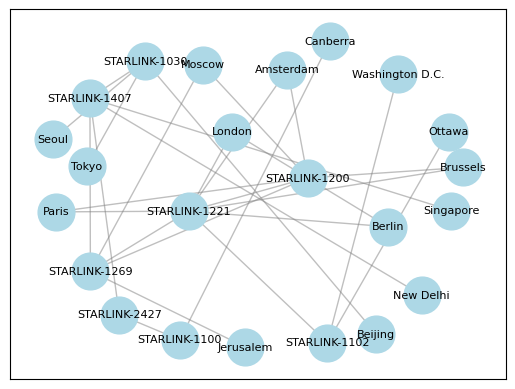

In [32]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming `sub_graph` contains your network data where the keys are nodes and values are dictionaries of neighbors with efficiencies as edge weights
# Also assuming `paths` contains the most efficient path from one city to another as determined previously

# Initialize the graph
G = nx.Graph()

# Add nodes and edges to the graph
for node, edges in sub_graph.items():
    G.add_node(node)
    for edge, weight in edges.items():
        G.add_edge(node, edge, weight=weight)

# Position nodes using NetworkX's spring layout
pos = nx.spring_layout(G)

# Draw the network
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', label='Satellites and Ground Stations')
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=8)

# Highlight the most efficient paths (example for one path, replicate as needed)
path = paths.get(('CityA', 'CityB'))  # Replace 'CityA' and 'CityB' with actual city names
if path:
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, label='Most Efficient Path')

plt.title("Quantum Communication Network")
plt.axis('off')
plt.legend()
plt.show()


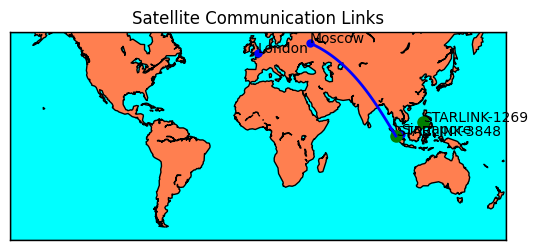

In [33]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Example city locations (latitude and longitude)
city_locations = {
    'Moscow': (55.7558, 37.6173),
    'London': (51.5074, -0.1278),
    'Singapore': (1.3521, 103.8198),
    # Add more cities as needed
}

# Example satellite locations
satellite_locations = {
    'STARLINK-3848': (0, 100),  # Replace with actual latitude and longitude
    'STARLINK-1269': (10, 120),  # Replace with actual latitude and longitude
    # Add more satellites as needed
}

# Initialize the basemap
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=60, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral',lake_color='aqua')
m.drawcoastlines()

# Plot cities
for city, (lat, lon) in city_locations.items():
    x, y = m(lon, lat)
    m.plot(x, y, 'bo', markersize=5)
    plt.text(x, y, city)

# Plot satellites
for sat, (lat, lon) in satellite_locations.items():
    x, y = m(lon, lat)
    m.plot(x, y, 'go', markersize=8)  # 'go' for green circle markers
    plt.text(x, y, sat)

# Draw links between satellites and cities (example link)
# Add similar blocks for each link you wish to plot
if 'Moscow' in city_locations and 'STARLINK-3848' in satellite_locations:
    city_lat, city_lon = city_locations['Moscow']
    sat_lat, sat_lon = satellite_locations['STARLINK-3848']
    m.drawgreatcircle(city_lon, city_lat, sat_lon, sat_lat, linewidth=2, color='b')

plt.title('Satellite Communication Links')
plt.show()


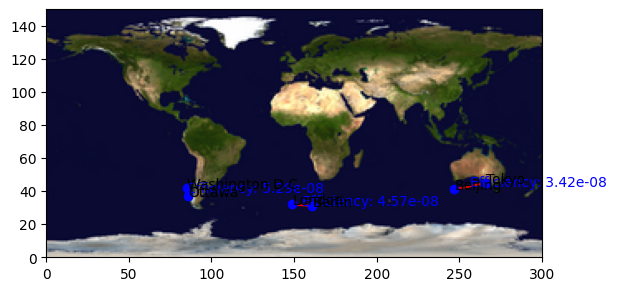

In [35]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to convert lat/lon to pixel coordinates (example conversion, adjust as necessary)
def latlon_to_pixels(lat, lon, width, height):
    # Assuming the image represents the coordinate system projected onto a rectangle
    lat_range = (-90, 90)
    lon_range = (-180, 180)
    
    # Map the lat/lon to the range [0, 1]
    lat_ratio = (lat - lat_range[0]) / (lat_range[1] - lat_range[0])
    lon_ratio = (lon - lon_range[0]) / (lon_range[1] - lon_range[0])
    
    # Convert the ratios to pixel positions
    x = lon_ratio * width
    y = height - lat_ratio * height
    return int(x), int(y)

# Load the world map image
image_path = 'earth_map.png'  # Replace with your image file path
world_map = plt.imread(image_path)
height, width = world_map.shape[:2]

# Define city coordinates
city_coords = {
    'Beijing': (39.9042, 116.4074),
    'Tokyo': (35.6895, 139.6917),
    'Berlin': (52.5200, 13.4050),
    'London': (51.5074, -0.1278),
    'Washington D.C.': (38.9072, -77.0369),
    'Ottawa': (45.4215, -75.6972),
}

# Define the paths and their efficiencies
paths = {
    ('Beijing', 'Tokyo'): 3.421184117293961e-08,
    ('Berlin', 'London'): 4.5680122185723066e-08,
    ('Washington D.C.', 'Ottawa'): 5.289096050927529e-08,
}

# Create the plot
fig, ax = plt.subplots()
ax.imshow(world_map, extent=[0, width, 0, height])

# Plot the paths
for (city1, city2), efficiency in paths.items():
    x1, y1 = latlon_to_pixels(*city_coords[city1], width, height)
    x2, y2 = latlon_to_pixels(*city_coords[city2], width, height)
    ax.plot([x1, x2], [y1, y2], 'r-')  # Red line for the path
    ax.text((x1+x2)/2, (y1+y2)/2, f"Efficiency: {efficiency:.2e}", color='blue')

# Plot city markers
for city, (lat, lon) in city_coords.items():
    x, y = latlon_to_pixels(lat, lon, width, height)
    ax.plot(x, y, 'bo')  # Blue dot for the city
    ax.text(x, y, city)

plt.show()


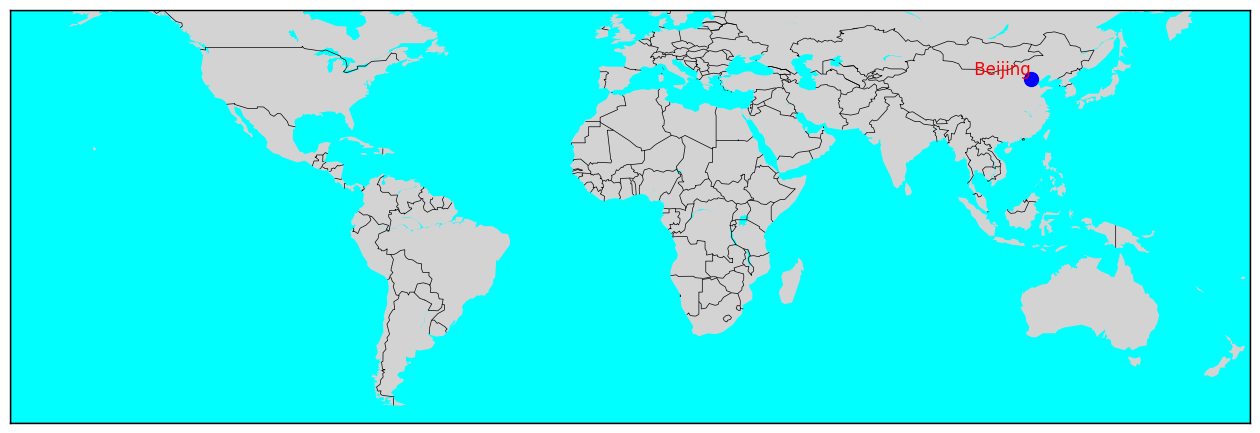

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Define the location of Beijing
beijing_coord = (39.9042, 116.4074)

# Load the world map image
image_path = '/mnt/data/image.png'

# Create a figure
plt.figure(figsize=(16, 8))

# Set up the Basemap
m = Basemap(projection='cyl', llcrnrlat=-60, urcrnrlat=60, llcrnrlon=-180, urcrnrlon=180)

# Draw map
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawcountries()

# Draw Beijing
x, y = m(beijing_coord[1], beijing_coord[0])
m.plot(x, y, 'bo', markersize=10)  # Plot a blue dot at Beijing's location
plt.text(x, y, ' Beijing', fontsize=12, ha='right', va='bottom', color='red')

plt.show()


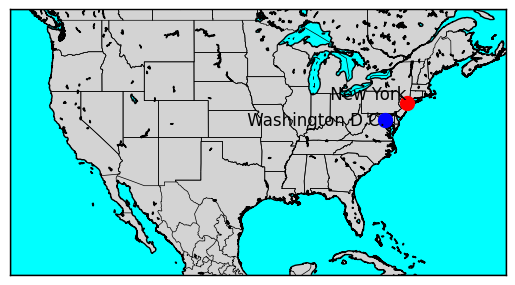

In [37]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Define the locations
new_york_coord = (40.7128, -74.0060)
washington_dc_coord = (38.9072, -77.0369)

# Create a figure
fig, ax = plt.subplots()

# Set up the Basemap
m = Basemap(projection='merc', llcrnrlat=20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='i')

# Draw map details
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

# Draw New York
ny_x, ny_y = m(new_york_coord[1], new_york_coord[0])
m.plot(ny_x, ny_y, 'o', color='red', markersize=10)
plt.text(ny_x, ny_y, ' New York', fontsize=12, ha='right', va='bottom', color='black')

# Draw Washington D.C.
dc_x, dc_y = m(washington_dc_coord[1], washington_dc_coord[0])
m.plot(dc_x, dc_y, 'o', color='blue', markersize=10)
plt.text(dc_x, dc_y, ' Washington D.C.', fontsize=12, ha='right', va='center', color='black')

# Display the plot
plt.show()


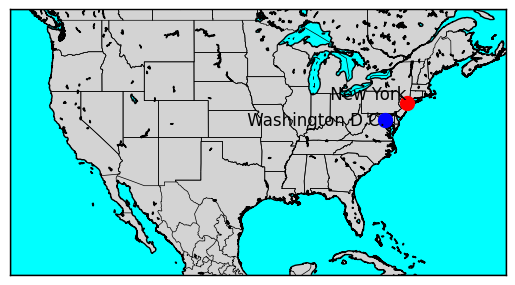

In [39]:
import os
import sys

# Path to the downloaded TLE data file
file_path = './dataset/satellite_tle.txt'

if not os.path.exists(file_path):
    print("file not exist")
    sys.exit()
    
from skyfield.api import load, EarthSatellite
import re
import math
from math import radians, degrees, sin, cos, asin, sqrt, pi, acos
import json
import numpy as np



# Function to parse TLE data
def parse_tle(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Dictionary to store TLE data
    tle_data = {}
    for i in range(0, len(lines), 3):
        satellite_name = lines[i].strip()
        line1 = lines[i + 1].strip()
        line2 = lines[i + 2].strip()

        # Extract launch year from the TLE data
        # The launch year is the first two digits of the last number in line 1
        match = re.search(r"1 \d{5}U (\d{2})(\d{3}[A-Z])", line1)
        if match:
            launch_year = int(match.group(1))
            # Convert to full year (assumes 2000s)
            launch_year += 2000

            # Check if the satellite was launched before 2024
            if launch_year < 2024:
                tle_data[satellite_name] = [line1, line2]

    return tle_data

# Parse the TLE data
parsed_tle_data = parse_tle(file_path)

# Load time scale and set specific time for calculations
ts = load.timescale()
specific_time = ts.utc(2024, 1, 1, 0, 0, 0)

# Initialize dictionary to store satellite positions
satellite_positions = {}

nan = float('nan')
# Calculating the position of each satellite at the specific time
for sat_name, tle in parsed_tle_data.items():
    satellite = EarthSatellite(tle[0], tle[1], sat_name, ts)
    geocentric = satellite.at(specific_time)
    subpoint = geocentric.subpoint()
    altitude = subpoint.elevation.km
    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees
    if np.isnan(altitude) or np.isnan(latitude) or np.isnan(longitude):
        continue

    # Store data in dictionary
    satellite_positions[sat_name] = {
        "altitude": altitude,
        "latitude": latitude,
        "longitude": longitude
    }

In [41]:
satellite_positions['STARLINK-1102']

{'altitude': 492.98457687695,
 'latitude': 53.20094512602645,
 'longitude': -71.55787369532206}

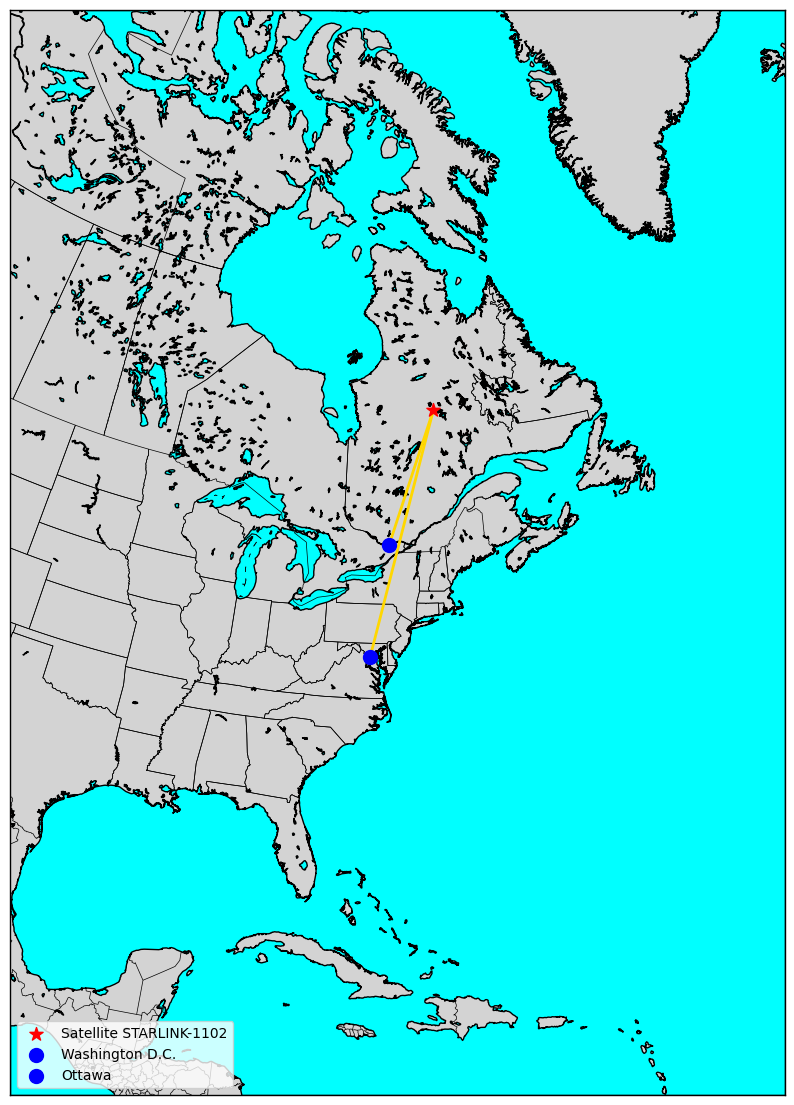

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Satellite and cities coordinates
satellite_coords = {
    'STARLINK-1102': {'altitude': 492.98457687695, 'latitude': 53.20094512602645, 'longitude': -71.55787369532206}
}

city_coords = {
    'Washington D.C.': (38.9072, -77.0369),
    'Ottawa': (45.4215, -75.6972)
}

# Create a figure
fig, ax = plt.subplots(figsize=(10, 20))

# Set up the Basemap - focusing on North America
m = Basemap(projection='lcc', resolution='i', lat_0=45, lon_0=-75, width=5E6, height=7E6)

# Draw map details
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawmapboundary(fill_color='aqua')

# Draw satellite
sat = satellite_coords['STARLINK-1102']
sat_x, sat_y = m(sat['longitude'], sat['latitude'])
m.scatter(sat_x, sat_y, s=100, c='red', marker='*', label='Satellite STARLINK-1102', zorder=5)

# Draw cities and connect them to the satellite
for city, (lat, lon) in city_coords.items():
    city_x, city_y = m(lon, lat)
    m.scatter(city_x, city_y, s=100, c='blue', marker='o', label=f'{city}', zorder=5)
    # Draw line from satellite to city
    m.drawgreatcircle(sat['longitude'], sat['latitude'], lon, lat, color='gold', linewidth=2, zorder=2)

# Add legend
plt.legend(loc='lower left')

# Display the plot
plt.show()


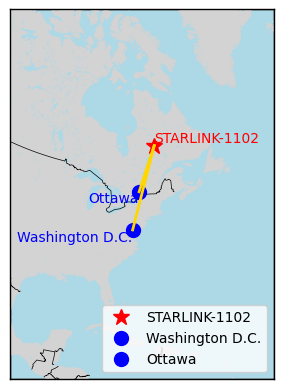

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Define the satellite and city coordinates
satellite_coords = {'STARLINK-1102': {'latitude': 53.20094512602645, 'longitude': -71.55787369532206}}
city_coords = {'Washington D.C.': (38.9072, -77.0369), 'Ottawa': (45.4215, -75.6972)}

# Set up the Basemap - focusing on North America for better clarity
m = Basemap(projection='lcc', resolution='i', lat_0=50, lon_0=-80, width=3E6, height=2E6)
# Set up the Basemap - focusing on North America
m = Basemap(projection='lcc', resolution='i', lat_0=45, lon_0=-75, width=5E6, height=7E6)

# Draw map details
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Draw the satellite and city locations
for name, coord in satellite_coords.items():
    x, y = m(coord['longitude'], coord['latitude'])
    m.plot(x, y, 'r*', markersize=12, label=name)
    plt.text(x, y, name, fontsize=10, ha='left', va='bottom', color='red')

for name, (lat, lon) in city_coords.items():
    x, y = m(lon, lat)
    m.plot(x, y, 'bo', markersize=10, label=name)
    plt.text(x, y, name, fontsize=10, ha='right', va='top', color='blue')

# Draw lines for the satellite communication links
for city_name, city_coord in city_coords.items():
    sat_name, sat_coord = next(iter(satellite_coords.items()))
    m.drawgreatcircle(city_coord[1], city_coord[0], sat_coord['longitude'], sat_coord['latitude'], 
                      linewidth=2, color='gold')

plt.legend()
plt.show()
